In [2]:
#load libraries
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from textblob import TextBlob

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis

In [3]:
df = pd.read_csv('Downloads/news_chicago_il.csv')
df.head()

,Unnamed: 0,crawled_date,language,text,title
0,0,2020-05-11,english,\nGov. Jay “Fatso” Pritzker called on all Illi...,All In Illinois
1,1,2020-05-11,english,"May 10, 2020 -The Illinois Department of Publi...",The Illinois Department of Public Health Annou...
2,2,2020-05-11,english,"Gloria Lawrence said: May 10, 2020 at 1:31 AM\...","Foto Friday: Alton, Illinois"
3,3,2020-05-11,english,NBA to follow German soccer league model with ...,Chris Broussard on Michael Jordan returning to...
4,4,2020-05-11,english,"Search Minggu, 10 Mei 2020 Pork chops vs. peop...",Pork chops vs. people: Can Americans’ appetite...


# Clean-up the noise (eliminate articles irrelevant to the analysis)

In [4]:
#filter for articles in English
df = df[df['language']=='english'].reset_index(drop=True)

#drop unnecessary columns
df = df.drop(columns = ['crawled_date','language',"Unnamed: 0"])

#join title and text into one column
news = df['title'].str.cat(df['text'],sep=" ")

#filter for articles that contains the word "population"
news = news[news.str.contains('population')].reset_index(drop=True)

#remove special symbols
news = news.map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

news.head()

0    Mayor Lightfoot announces plans for reopening ...
1    Jushi Announces the Beginning of AdultUse Cann...
2    Jushi Announces the Beginning of AdultUse Cann...
3    Pope Francis Names Father Louis Tylka of Archd...
4    Coronavirus in Illinois updates: Heres whats h...
Name: title, dtype: object

# Filtered With Keyword Extraction

We filtered out articles whose top 10 keywords does not includes the word "population".

In [116]:
arti = []

for i in range(len(news)):
    r = Rake()
    r.extract_keywords_from_text(news[i])
    keywords = r.get_ranked_phrases()[:10]
    
    
    if sum(keywords[j].count('population') for j in range(len(keywords))) > 0:
        arti.append(news[i])


In [117]:
len(arti)

715

# Sentiment Analysis with TextBlob

In [194]:
polarity = []

for i in range(len(arti)):
    polarity.append(TextBlob(arti[i]).sentiment.polarity)

    
data_tb = {"article":arti,"polarity":polarity}
sentiment_tb = pd.DataFrame(data_tb, columns = ["article","polarity"])
sentiment_tb.head()

,article,polarity
0,Illinois Gov. J.B. Pritzker in isolation after...,0.006140
1,Take A Look At These Coyotes Running Around Ch...,0.075000
2,"Goodbye, New York, California and Illinois. He...",0.134579
3,Data Research Internship at University of Chic...,0.232421
4,Whats unique about the patient populations in ...,0.393750


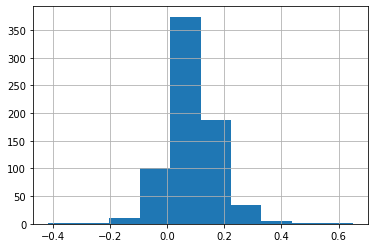

In [195]:
sentiment_tb.polarity.hist()

Comment: Textblob sentiment analyzer does not perform very well to our data based on the distribution histogram. We can see that most of our articles are classified in the center around 0, with majority of the articles in the 0 and 0.2 zone. Since the result is not well spread, we would suggest to try another sentiment analysis to see if we can get better result.

# NLTK Vader Sentiment Analysis

In [122]:
analyzer = SentimentIntensityAnalyzer()

compound = []

for i in range(len(arti)):
    compound.append(analyzer.polarity_scores(arti[i])['compound'])

    
data_vd = {"article":arti,"compound":compound}
sentiment_vd = pd.DataFrame(data_vd, columns = ["article","compound"])
sentiment_vd.head()

,article,compound
0,Illinois Gov. J.B. Pritzker in isolation after...,0.7861
1,Take A Look At These Coyotes Running Around Ch...,0.5789
2,"Goodbye, New York, California and Illinois. He...",-0.6677
3,Data Research Internship at University of Chic...,0.9939
4,Whats unique about the patient populations in ...,0.8122


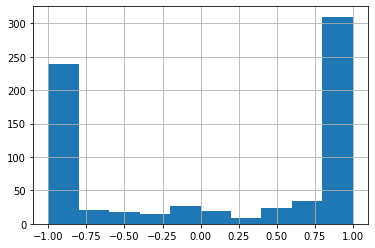

In [123]:
sentiment_vd['compound'].hist()

Comments: We can see NTLK Vader performs slightly better as compared to textblob. There are higher counts of articles on both strongly positive and strongly negative side. Therefore we decided to separate our data using the sentiment score with NTLK Vader. 

# separate positive and negative articles

In [124]:

pos = sentiment_vd[sentiment_vd['compound'] >= 0]
neg = sentiment_vd[sentiment_vd['compound'] < 0]

#drop compound score
pos = pos["article"]
neg = neg["article"]
print(pos.shape)
print(neg.shape)

(416,)
(299,)


# Word Cloud for Positive and Negative Articles

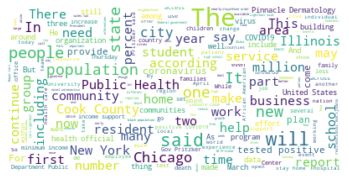

In [164]:
pos_text= ' '.join(pos)

stop_words = ["Illinois", "Chicago", "state", "city","U.S.", "United States","Illinois.","Chicago.", "States."] + list(STOPWORDS)
pos_text= ' '.join(pos)
cleanpos_text = [word for word in pos_text.split() if word not in stop_words]
pos_text= ' '.join(cleanpos_text)

wordcloud_pos = WordCloud( max_font_size=30, max_words=200, background_color="white").generate(pos_text)
plt.figure()
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.show()

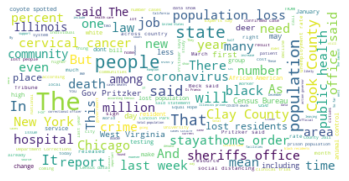

In [163]:
neg_text= ' '.join(neg)
cleanneg_text = [word for word in neg_text.split() if word not in stop_words]
neg_text= ' '.join(cleanneg_text)

wordcloud_neg = WordCloud(max_font_size=30, max_words=200, background_color="white").generate(neg_text)
plt.figure()
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

# Named Entity Recognition

In [127]:
#put all articles into one list
pos_article = []
for i in range(pos.shape[0]):
    pos_article.append(pos.iloc[i,])

pos_entities = []
pos_labels = []
for i in range(len(pos_article)):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(pos_article[i])), binary = False):
        if hasattr(chunk, 'label'):
            pos_entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
            pos_labels.append(chunk.label())

entities_pos = list(zip(pos_entities, pos_labels))

In [168]:
entities_pos = pd.DataFrame(entities_pos)
entities_pos.columns = ["Entities", "Labels"]
counts_pos = entities_pos.groupby('Entities').count()
counts_pos = counts_pos.sort_values(by=['Labels'], ascending = False)

In [185]:
counts_pos.loc[~counts_pos.index.isin(['Illinois', 'Chicago', 'U.S.', 'United States','Chicagos',
                      'Illinois Department','Chicago Department','City','city',"US","Department","Coronavirus","Census"])].head(30)

,Labels
Entities,
COVID19,595
Evanston,106
University,105
New York,99
American,94
Pritzker,74
Public Health,74
Senate,64
California,61


In [170]:
#put all articles into one list
neg_article = []
for i in range(neg.shape[0]):
    neg_article.append(neg.iloc[i,])

neg_entities = []
neg_labels = []
for i in range(len(neg_article)):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(neg_article[i])), binary = False):
        if hasattr(chunk, 'label'):
            neg_entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
            neg_labels.append(chunk.label())

entities_neg = list(zip(neg_entities, neg_labels))

In [171]:
entities_neg = pd.DataFrame(entities_neg)
entities_neg.columns = ["Entities", "Labels"]
counts_neg = entities_neg.groupby('Entities').count()
counts_neg = counts_neg.sort_values(by=['Labels'], ascending = False)

In [192]:
counts_neg.loc[~counts_neg.index.isin(['Illinois', 'Chicago', 'U.S.', 'United States','Chicagos',
                      'Illinois Department','Chicago Department','City','city',"US","Department"])].head(30)

,Labels
Entities,
COVID19,310
Bailey,80
New York,76
Cook County,61
Clay County,60
Pritzker,59
Census,54
West Virginia,54
California,49


# Prepare data for topics modeling

In [175]:
#lemmazation

exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop_words])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

pos_clean = [clean(doc).split() for doc in pos] 
neg_clean = [clean(doc).split() for doc in neg] 

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
pos_dictionary = corpora.Dictionary(pos_clean)
neg_dictionary = corpora.Dictionary(neg_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
pos_matrix = [pos_dictionary.doc2bow(doc) for doc in pos_clean]
neg_matrix = [neg_dictionary.doc2bow(doc) for doc in neg_clean]

# Build LDA model for Topics

In [176]:
pos_lda = []
neg_lda = []

for i in range(1,20,2):
    Lda = gensim.models.ldamodel.LdaModel
    pos_model = Lda(pos_matrix, num_topics=i, id2word = pos_dictionary, passes=50)
    neg_model = Lda(neg_matrix, num_topics=i, id2word = neg_dictionary, passes=50)
    pos_lda.append(pos_model)
    neg_lda.append(neg_model)

In [177]:
pos_coherence_scores = []
neg_coherence_scores = []

for model in pos_lda:
    coherencemodel = CoherenceModel(model=model, texts=pos_clean, dictionary=pos_dictionary, coherence='c_v')
    pos_coherence_scores.append(coherencemodel.get_coherence())
    
for model in neg_lda:
    coherencemodel = CoherenceModel(model=model, texts=neg_clean, dictionary=neg_dictionary, coherence='c_v')
    neg_coherence_scores.append(coherencemodel.get_coherence())

Text(0, 0.5, 'Positive Articles Coherence Score')

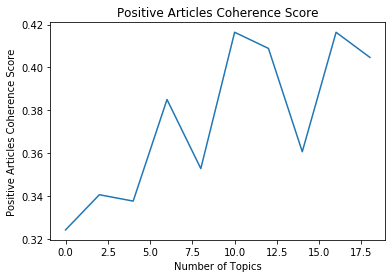

In [178]:
fig = plt.figure()
ax = plt.axes()
plt.plot(range(0,20,2), pos_coherence_scores)
plt.title("Positive Articles Coherence Score")
plt.xlabel("Number of Topics")
plt.ylabel("Positive Articles Coherence Score")

Text(0, 0.5, 'Negative Articles Coherence Score')

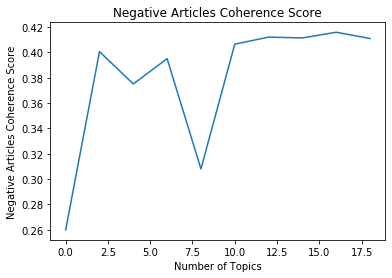

In [179]:
fig = plt.figure()
ax = plt.axes()
plt.plot(range(0,20,2), neg_coherence_scores)
plt.title("Negative Articles Coherence Score")
plt.xlabel("Number of Topics")
plt.ylabel("Negative Articles Coherence Score")

Comment: Based on the Coherence score, we select number of topics equals to 16 for positive articles and number of topics equals to 6 for negative articles. 

In [188]:
print(*pos_lda[9].print_topics(num_topics=10, num_words=4), sep='\n')

(4, '0.015*"people" + 0.012*"support" + 0.011*"minimum" + 0.011*"income"')
(9, '0.055*"dermatology" + 0.027*"pinnacle" + 0.025*"patient" + 0.016*"brighton"')
(10, '0.023*"chicago" + 0.016*"illinois" + 0.011*"population" + 0.010*"black"')
(6, '0.015*"case" + 0.011*"number" + 0.011*"covid19" + 0.010*"county"')
(7, '0.016*"will" + 0.011*"antibody" + 0.010*"chicago" + 0.009*"covid19"')
(12, '0.007*"obama" + 0.005*"planting" + 0.004*"illinois" + 0.004*"said"')
(1, '0.015*"deer" + 0.013*"season" + 0.011*"illinois" + 0.010*"lodge"')
(16, '0.020*"illinois" + 0.014*"population" + 0.014*"chicago" + 0.011*"state"')
(5, '0.015*"covid19" + 0.014*"said" + 0.013*"case" + 0.013*"illinois"')
(18, '0.023*"illinois" + 0.008*"population" + 0.007*"said" + 0.007*"year"')


In [189]:
print(*neg_lda[9].print_topics(num_topics=10, num_words=4), sep='\n')

(8, '0.016*"illinois" + 0.008*"chicago" + 0.008*"said" + 0.007*"site"')
(12, '0.024*"prison" + 0.016*"inmate" + 0.012*"prisoner" + 0.011*"said"')
(18, '0.038*"cancer" + 0.023*"cervical" + 0.014*"woman" + 0.010*"said"')
(3, '0.020*"illinois" + 0.018*"population" + 0.014*"state" + 0.012*"people"')
(4, '0.011*"bail" + 0.011*"chicago" + 0.010*"court" + 0.010*"marijuana"')
(7, '0.012*"said" + 0.010*"chicago" + 0.010*"people" + 0.009*"black"')
(10, '0.014*"clinical" + 0.014*"trial" + 0.014*"patient" + 0.010*"cancer"')
(16, '0.010*"coronavirus" + 0.008*"sale" + 0.007*"jail" + 0.007*"order"')
(2, '0.017*"illinois" + 0.013*"adult" + 0.012*"population" + 0.009*"risk"')
(11, '0.025*"detainee" + 0.016*"jail" + 0.016*"officer" + 0.012*"said"')


In [182]:
import pyLDAvis.gensim
lda_display_pos = pyLDAvis.gensim.prepare(pos_lda[9], pos_matrix, pos_dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_pos)

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [183]:
lda_display_neg = pyLDAvis.gensim.prepare(neg_lda[9], neg_matrix, neg_dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_neg)

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Please see PPT for comments and actionable recommendations.